# Flight cancellation analysis
## by Valeriya Petrenko

## Investigation Overview

> Using the data for Flight cancellation over the last 30 years (1988-2018 years), I'll try to find any patterns during each year, assess seasonal cancellations and how different flight cancellations across airlines

## Dataset Overview

> The data was collected from the Bureau of Transportation and Statistics. First I obtained preprocessed data for 1988-2003 years, then I ammended it with data from website for each subsequent year up to 2019.

> incomplete years 1988 and 2019 were excluded from the analysis

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from datetime import datetime
import geopandas as gpd

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")
import warnings
warnings.filterwarnings('ignore')
from utils import *

In [16]:
cancellation_fname = "./df_cancellation_1988-2018.pkl"
if not os.path.exists(cancellation_fname):
    print("First run data-preparation notebook")
else:
    df = pd.read_pickle(cancellation_fname)

carriers = df.UniqueCarrier.unique()

df_carrier = pd.read_csv("./carriers.csv")
df_airport = pd.read_csv("./data/data/airports.csv")

## Number of flights by carriers

> I'll focus only on large companies (i.e. the ones that have more than 1 million of flights total)

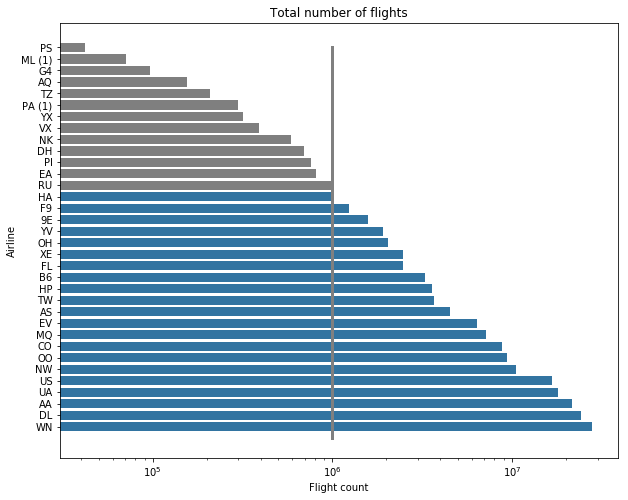

In [3]:
min_flights_total = 1e6
df_c = df.groupby(['UniqueCarrier']).sum().sort_values(['Flights'])[['Flights', 'Cancelled']].reset_index()
grey = sns.color_palette()[7]
blue = sns.color_palette()[0]
palette = df_c.Flights.apply(lambda x: x > min_flights_total and blue or grey).values
f, ax = plt.subplots(figsize=(10, 8))
plot = sns.barplot(y=df_c.UniqueCarrier, x=df_c.Flights, palette=palette)
plt.plot([min_flights_total, min_flights_total], [0, len(carriers)], linewidth=3, color="grey")
plt.title("Total number of flights");
ax.set(xscale="log")
plt.ylabel("Airline");
plt.xlabel("Flight count");

## Fraction of cancelled flights each year

> Let's see the dynamics of the number of cancelled flights across all years

Cancelled/total flights ratio over 30 years: 1.8 %


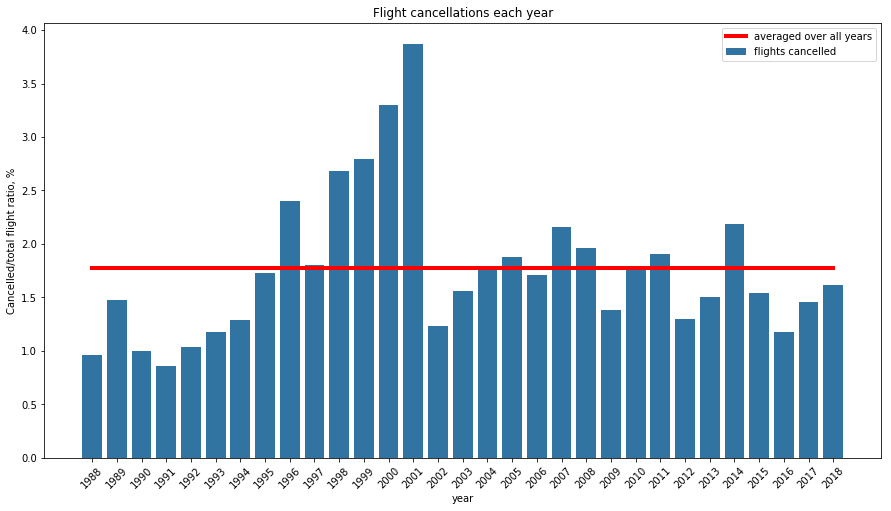

In [4]:
def percent_group_by_column(df, cols):
    res_cancel = df.groupby(cols)['Cancelled'].sum()
    res_total = df.groupby(cols)['Flights'].sum()
    # let's normalize data by dividing total number of cancellations by the total number of flights
    res_norm = res_cancel/res_total * 100
    res_norm.name = "Cancelled"
    res_norm = res_norm.reset_index()
    return res_total, res_norm

cancelled = df.Cancelled.sum() / df.Flights.sum()
cancelled_p = cancelled * 100
print("Cancelled/total flights ratio over 30 years: {:.2} %".format(cancelled_p))

dft, dfy = percent_group_by_column(df, ["Year"])
years = dfy.Year
f, ax = plt.subplots(figsize=(15, 8), nrows=1)
base_color = sns.color_palette()[0]
plot = sns.barplot(y="Cancelled", x="Year", color=base_color, data=dfy, 
                   label='flights cancelled')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45);
plt.plot([0, len(years)-1], [cancelled_p, cancelled_p], linewidth=4, color="red", 
         label='averaged over all years');
plt.title("Flight cancellations each year");
plt.legend();
plt.ylabel("Cancelled/total flight ratio, %");
plt.xlabel("year");

## Are there seasonal patterns of cancelled flights across the years

> we can see that in general, winter months have more cancellations than the rest of the year

> also, clearly tragic 9/11 event is shown as an outlier among all cancellations

> interestingly enough, before the 2001, there was consistent increase in flight cancellations during 1998-2001 period

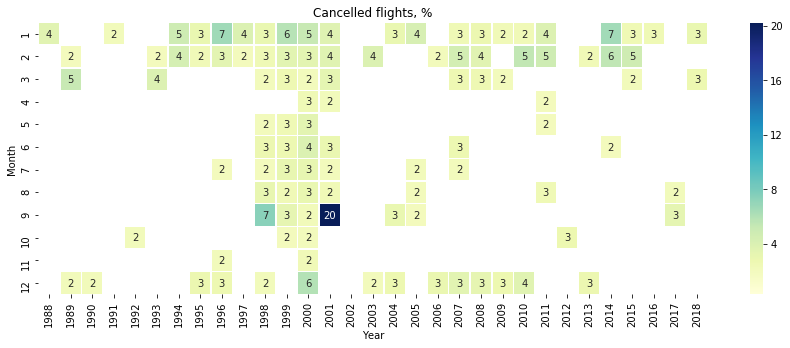

In [5]:
dft, dfym = percent_group_by_column(df, cols=["Year", "Month"])
dfym_pivot = dfym.pivot(index="Month", columns="Year", values="Cancelled")
plt.figure(figsize=(15, 5))
mask = dfym_pivot < 2
ax = sns.heatmap(dfym_pivot, annot=True,  cmap='YlGnBu', fmt=".0f", linewidth=0.5, mask=mask)
plt.title("Cancelled flights, %");
plt.xlabel("Year");
plt.ylabel("Month");

### Percentage of cancelled flights each month

> There is a clear pattern for the seasonal flight cancellation dependency

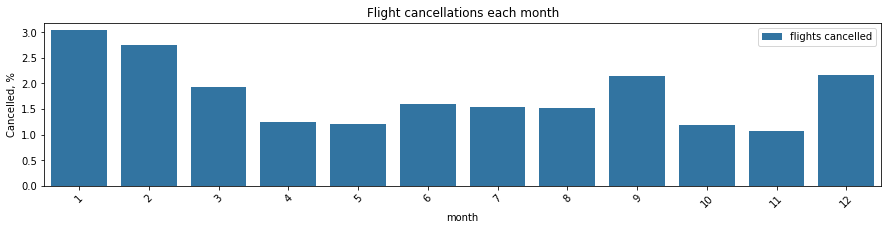

In [6]:
dft, dfm = percent_group_by_column(df, ["Month"])
f, ax = plt.subplots(figsize=(15, 3), nrows=1)
base_color = sns.color_palette()[0]
plot = sns.barplot(y="Cancelled", x="Month", color=base_color, data=dfm, 
                   label='flights cancelled')
plot.set_xticklabels(plot.get_xticklabels(), rotation=45);
plt.title("Flight cancellations each month");
plt.legend();
plt.ylabel("Cancelled, %");
plt.xlabel("month");

## Flight cancellation by carrier

> the carriers greatly differ by how many of the total flighs are cancelled

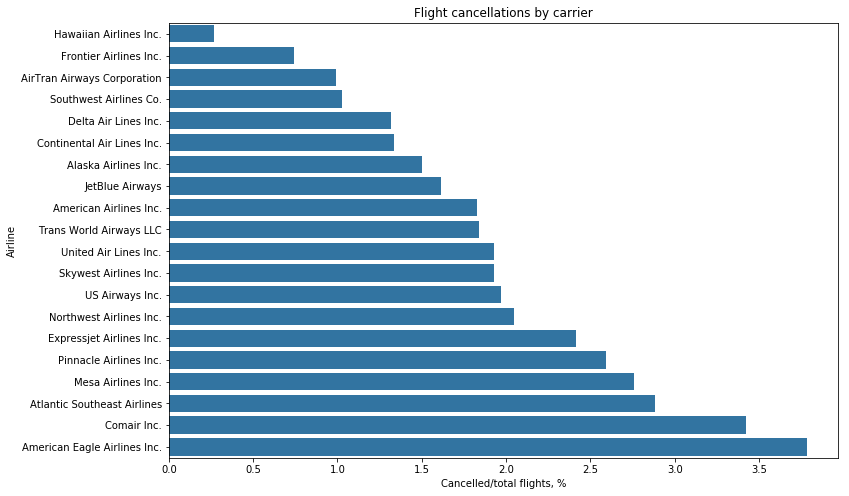

In [9]:
df_temp = df_c[df_c.Flights > min_flights_total][['UniqueCarrier']]
df_carrier_large = df_carrier.merge(df_temp, how="inner", right_on="UniqueCarrier", left_on="Code")\
                             .drop('Code', axis=1)\
                             .set_index(['UniqueCarrier'])
df_carrier_large.loc['US'] = "US Airways Inc."
df_carrier_large = df_carrier_large.drop('HP').reset_index()
df = df.merge(df_carrier_large, how="inner", on="UniqueCarrier")

dft, dfc = percent_group_by_column(df, ["Description"])
dfc = dfc.sort_values('Cancelled')
f, ax = plt.subplots(figsize=(12, 8), nrows=1)
base_color = sns.color_palette()[0]
plot = sns.barplot(x="Cancelled", y="Description", color=base_color, data=dfc)
plt.title("Flight cancellations by carrier");
plt.xlabel("Cancelled/total flights, %");
plt.ylabel("Airline");

## Flight cancellation in each state (as destination)

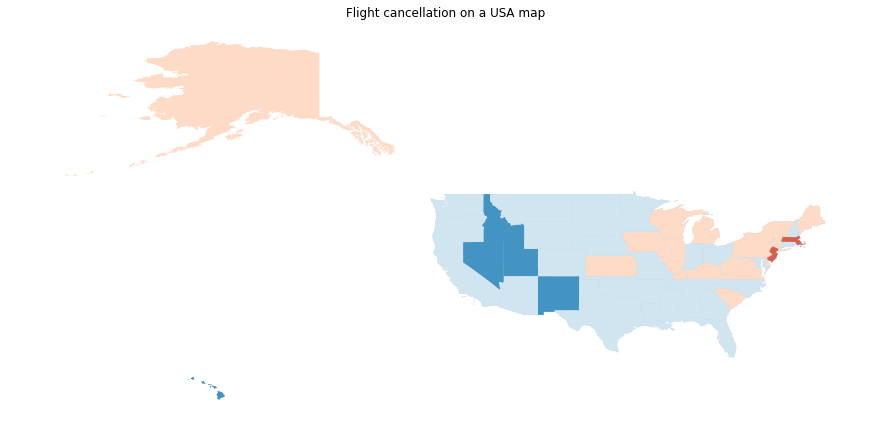

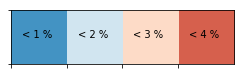

In [17]:
def color_by_rate(x):
    colors = sns.color_palette("RdBu", n_colors=4)
    return colors[3 - int(x % 4)]

usa = gpd.read_file('states_21basic/states.shp')
df = df.merge(df_airport, how="inner", left_on="Dest", right_on="iata").drop('iata', axis=1)

dft, dfs = percent_group_by_column(df, ["state"])
dfs = dfs.sort_values('Cancelled')
dfs['colors'] = dfs.Cancelled.apply(color_by_rate)

def state_plotter(states, colors, us_map=True):
    fig, ax = plt.subplots(figsize=(15,20))
    plt.axis("off")
    plt.title("Flight cancellation on a USA map")
    usa_plot = usa
    if us_map:
        if 'HI' in states: # hawaii
            usa_plot = usa[:50]
        elif 'AK' in states: # alaska
            usa_plot = usa[1:51]
        elif 'AK' and 'HI' in states:
            usa_plot = usa[:51]
        else:
            usa_plot = usa[1:50]
        usa_plot.plot(ax=ax, alpha=0.3)

    for n, c in zip(states, colors):
        if n in usa.STATE_ABBR.values:
            usa[usa.STATE_ABBR == f'{n}'].plot(ax=ax, edgecolor=None, linewidth=2, color=c)
    # 0 < blue < 1
    # 1 < mint < 2
    # 2 < orange < 3
    # 3 < red < 4
    sns.palplot(sns.color_palette("RdBu", n_colors=4)[::-1])
    for i in range(4):
        x = i+1
        plt.text(-.3+i, 0, f"< {x} %")

state_plotter(dfs.state.values, dfs.colors.values)